In [34]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix

In [20]:
df = pd.read_csv('data/diabetes_prediction_dataset.csv')

In [43]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,target
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   target               100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [21]:
# Rename the target column for clarity
df.rename(columns={'diabetes': 'target'}, inplace=True)

# Categorical columns and numerical columns
categorical_columns = ['gender', 'smoking_history']
numerical_columns = [col for col in df.columns if col not in categorical_columns + ['target']]

# Define ColumnTransformer to handle different types of data
preprocessor = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    (StandardScaler(), numerical_columns)
)

In [22]:
# Split the data into features and target
X = df.drop('target', axis=1)
y = df['target']

In [23]:
# Preprocess data (apply transformations) before applying SMOTE
X_preprocessed = preprocessor.fit_transform(X)

# Apply SMOTE to the preprocessed data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

In [24]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [25]:
# Define the model
model = RandomForestClassifier(random_state=42)

In [26]:
pipeline = Pipeline(steps=[('classifier', model)])

# Hyperparameter tuning using GridSearchCV

In [28]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best estimator
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [33]:
# Predictions and evaluation
y_pred = best_model.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc:.2f}")

# Display classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 97.67%
ROC AUC Score: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     18293
           1       0.97      0.98      0.98     18307

    accuracy                           0.98     36600
   macro avg       0.98      0.98      0.98     36600
weighted avg       0.98      0.98      0.98     36600



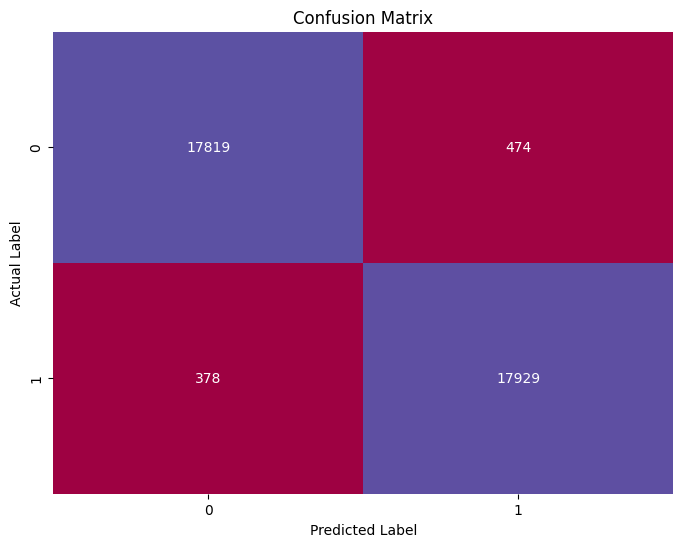

In [42]:
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Spectral", cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

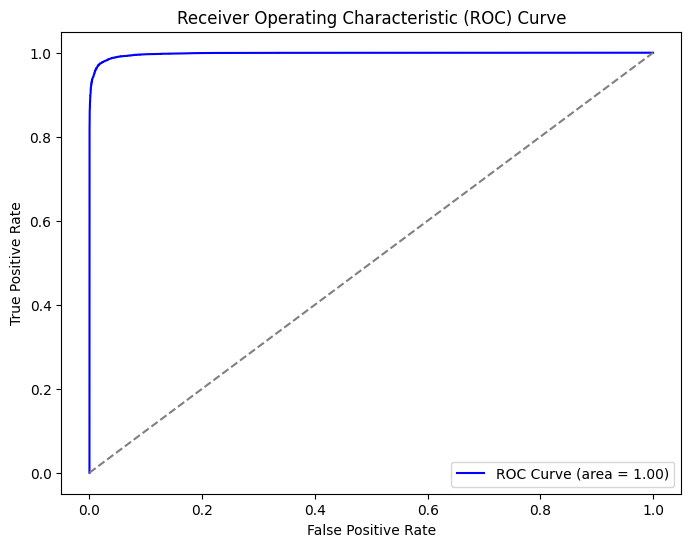

In [37]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()